In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn import datasets
%matplotlib inline

In [2]:
# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=1000, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=1)

# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (700, 2)
Размер массива признаков тестовой выборки (300, 2)
Размер массива ответов для обучающей выборки (700,)
Размер массива ответов для тестовой выборки (300,)


In [3]:
def confusion(predicted, actual):
    TP=np.sum(np.logical_and(predicted==1, actual==1))
    FP=np.sum(np.logical_and(predicted==1, actual==0))
    FN=np.sum(np.logical_and(predicted==0, actual==1))
    TN=np.sum(np.logical_and(predicted==0, actual==0))
    return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}

In [4]:
class logistic_regression:
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations=1000
        self.eta=eta
    @staticmethod
    def log_grad(w, c, X, target):
        m = X.shape[0]
        y=(2*target-1)
        score=np.dot(X, w.T).flatten()
        Z=-y/(m*(1+np.exp(y*score)))
        grad=Z[np.newaxis, :].dot(X)
        return grad/m, np.sum(Z)/m
    @classmethod
    def optimize(cls, w, c, X, y, n_iterations, eta):
        for i in range(n_iterations):        
            grad_w, grad_c = cls.log_grad(w, c, X, y)
            w = w - eta * grad_w
            c = c - eta * grad_c
        return w, c
    def fit(self, X, y):
        w0 = np.zeros((1, X.shape[1]))
        c0=0
        self.w, self.c= self.optimize(w0, c0, X, y, self.n_iterations, self.eta)
    def predict_proba(self, X):  
        '''
        Рассчёт вероятности
        '''
        score=X.dot(self.w.T).flatten()+self.c
        return 1/(1+np.exp(-score))
    def predict(self, X, thr=0.5):
        proba=self.predict_proba(X)
        y_predicted = np.zeros(proba.shape, dtype=bool) 
        y_predicted[proba>thr]=1
        y_predicted[proba<=thr]=0
        return y_predicted

In [5]:
mod=logistic_regression()

mod.fit(X_train, y_train)

y_predicted_test = mod.predict(X_test)
order = np.argsort(mod.predict_proba(X_test))
order_targets = y_test[order]

print(confusion(y_predicted_test, y_test))

num_pos=np.sum(order_targets)
num_neg=len(order_targets)-num_pos
print(f'{num_pos} объектов положительного класса, {num_neg} объектов негативного класса')
print()

#Чувствительность
TPR=np.concatenate([[0], np.cumsum(1-order_targets)/num_neg])

#Ложно-позитивный уровень
FPR=np.concatenate([[0], np.cumsum(order_targets)/num_pos])

{'TP': 122, 'FP': 31, 'FN': 16, 'TN': 131}
138 объектов положительного класса, 162 объектов негативного класса



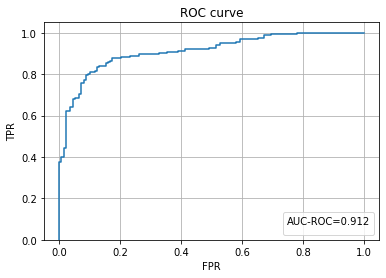

In [6]:
AUC_ROC = np.sum(0.5*(FPR[1:]-FPR[:-1])*(TPR[1:]+TPR[:-1]))

precision=np.cumsum(1-order_targets)/(np.cumsum(1-order_targets)+np.cumsum(order_targets))
precision

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR)

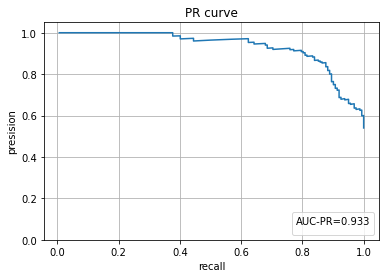

In [7]:
recall = TPR

AUC_PR = np.sum(precision*(recall[1:]-recall[:-1]))

plt.title('PR curve')
plt.ylim(0, 1.05)
plt.xlabel('recall')
plt.ylabel('presision')
plt.grid()
plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')
plt.plot(recall[1:], precision)

In [8]:
print(f'AUC_ROC = {AUC_ROC:.3f}, AUC_PR = {AUC_PR:.3f}')

AUC_ROC = 0.912, AUC_PR = 0.933
